In [146]:
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os
import random 

In [147]:
carpeta = (os.getcwd()+'/tc02Data/')

# Nombres de los archivos: yeast_(...).txt
archivos = ['Y2H','AP-MS','LIT','LIT_Reguly']

# Lista donde se van a ir agregando los grafos en el orden de los archivos
Gs = []

for j,archivo in enumerate(archivos):
    data = pd.read_csv(carpeta+'yeast_'+archivo+'.txt', sep='\t', header=None)
    
    G = nx.Graph()
    
    for i in range(len(data)):
        G.add_edges_from([(data[0][i],data[1][i])])
    Gs.append(G)

# El último archivo, LIT_Reguly, es el único que tiene encabezado
# Quise poner header automático pero devuelve un error, así que elimino lo que sobra a lo bruto
Gs[3].remove_node("Bait gene/protein")
Gs[3].remove_node("Hit gene/protein")

In [148]:
# Proteinas esenciales
data_ess = pd.read_csv(carpeta+'Essential_ORFs_paperHe.txt', sep='\t', header=0,skipfooter=4,usecols=[1])

# Para eliminar los espacios en los nombres de las proteinas
data_ess['ORF_name'] = data_ess['ORF_name'].map(lambda x: x.strip())

ess = data_ess["ORF_name"].tolist()
del ess[0] # como antes, elimino el encabezado

# ess es la lista de proteinas esenciales

C:\Users\Lucio\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


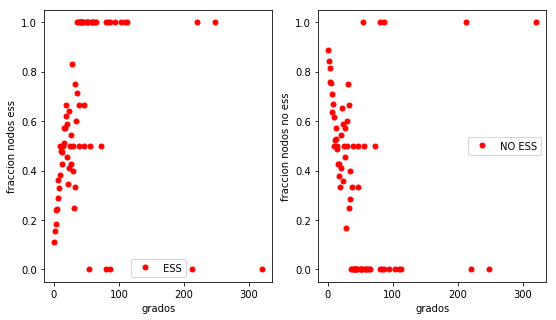

In [34]:
#Veamos como se comportan los graficos
from funciones import esenciales
from funciones import frac_ess
E=G.copy()
NE=G.copy()
L = len(G)

(E,nodos_ess, nodos_noess)=esenciales(G,ess)
x1, y1=frac_ess(E) 

(NE,nodos_ess, nodos_noess)=esenciales(NE,nodos_noess) #NE le saco le paso la lista de nodos no es como la lista de los es
x2, y2=frac_ess(NE) 


plt.figure(figsize=(9,5))

plt.subplot(1,2,1)
plt.plot(x1, y1,'r.',markersize=10,label='ESS')
plt.xlabel('grados')
plt.ylabel('fraccion nodos ess')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x2, y2,'r.',markersize=10,label='NO ESS')
plt.xlabel('grados')
plt.ylabel('fraccion nodos no ess')
plt.legend()

plt.show()


In [149]:
from funciones import esenciales
from funciones import frac_ess
#Creo copias superficiales de G porque solo me interesan sus nodos
G1 = G.copy()
G2 = G.copy()
    
L = len(G) # tamaño del grafo (cantidad de nodos)
    
lcc_ess= np.zeros(L) #componente gigante obtenida mediante remoción de nodos esenciales (eje y)
lcc_ess[0] = L # la primera componente es el tamaño original del grafo
    
lcc_noess= np.zeros(L) #componente gigante obtenida mediante remocion de nodos no esenciales (eje y)
lcc_noess[0] = L # la primera componente es el tamaño original del grafo
    
#Le saco todas las esenciales de una
(G1,ls_ess,ls_no_ess) = esenciales(G1,ess) #uso esta funcion para obtener las lista de las ess en G
G1.remove_nodes_from(ls_ess) #Le saco todos los esenciales
lcc_ess = len(max(nx.connected_component_subgraphs(G1),key=len))

#x=(len(lcc_ess))/L  #es la fraccion de nodos que quedan en la LCC
    

(g,nodos_ess, nodos_noess)=esenciales(G2,ls_no_ess) #a G2 le paso la lista de nodos no es, asi los selecciono más facil
    
no_ess_dict = nx.get_node_attributes(G2,'essential') #armo lista con los no esenciales, el 'essential' me esta marcando los no esenciales 
    
(x2, y2)=frac_ess(G2) 
l=len(x2)
    
for grado in range(l-1): #recorro los grados, y le saco a G2 la cantidad de nodos no esenciales en ese grado (saco ordenado de mM)
    counter=0
    for nodo in no_ess_dict:
        if (counter < len(ls_no_ess) and no_ess_dict[nodo] == True and G2.degree(nodo) == grado):
            G2.remove_node(ls_no_ess[counter])
            lcc_noess[counter+1] = len(max(nx.connected_component_subgraphs(G2),key=len)) #acá voy rellenando la lcc
        counter= counter+1
        
#y=(len(lcc_noess))/L

In [40]:
#x=(len(lcc_ess))/L

#y=(len(lcc_noess))/L

# Creamos la tabla con las caracteristicas de las redes
haytabla = pd.DataFrame({"Red":["G"],
                        "Frac. de nodos sacando: esenciales":x,
                        "Frac. de nodos sacando: no esenciales":y,
                        })
haytabla


,Red,Frac. de nodos sacando: esenciales,Frac. de nodos sacando: no esenciales
0,G,0.27094,0.27094


In [154]:
lcc_noess[2]

0.0